In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from scipy import stats
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from suitability.datasets.dollarstreet import DollarStreetDataset, get_dollarstreet
from suitability.filter.sample_signals import ConfidenceSignal, DecisionBoundarySignal, TrainingDynamicsSignal
from suitability.filter.tests import non_inferiority_test

random.seed(32)
np.random.seed(32)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root_dir = '/mfsnic/u/apouget/data/dollarstreet/dataset_dollarstreet/'

model = resnet50(weights=None)
state_dict = torch.load('/mfsnic/u/apouget/experiments/dollarstreet/best_model.pth')
model.load_state_dict(state_dict)
model.to(device)

REGIONS = ['eu', 'am', 'as', 'af']
confidences = {}
correctness = {}

for region in REGIONS:
    data = get_dollarstreet(root_dir, 'test', batch_size=64, shuffle=False, num_workers=4, pre_filter=lambda x: x['region.id'] == region)
    signal = ConfidenceSignal(model, data, device)
    conf, corr = signal.evaluate()
    confidences[region] = conf
    correctness[region] = corr
    print(f'Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct')

Region eu: 35.28% correct
Region am: 33.64% correct
Region as: 30.54% correct
Region af: 28.93% correct


In [8]:
for region in ['am', 'as', 'af']:
    print(f'Sample mean and variance for region {region}:', np.mean(confidences[region]), np.var(confidences[region]))
    print(f'EU vs {region}:', stats.ttest_ind(confidences['eu'], confidences[region], equal_var=False))

Sample mean and variance for region am: 0.5478275 0.060945105
EU vs am: TtestResult(statistic=1.0316236945381057, pvalue=0.3024212248423552, df=1443.684599597469)
Sample mean and variance for region as: 0.5316979 0.062059678
EU vs as: TtestResult(statistic=2.6032634066614935, pvalue=0.009350103695562122, df=1178.3091046781356)
Sample mean and variance for region af: 0.517687 0.058935497
EU vs af: TtestResult(statistic=3.380387254967134, pvalue=0.0007433244686163816, df=1431.136179194985)


In [6]:
# Function to perform t-tests and calculate accuracy for different sample sizes
def run_ttests_for_samples(confidences, correctness, sample_sizes):
    results = []
    
    for sample_size in sample_sizes:
        row = {'sample_size': sample_size}
        for region in ['am', 'as', 'af']:
            # Sample from the confidence scores and correctness of the region
            sampled_indices = random.sample(range(len(confidences[region])), min(sample_size, len(confidences[region])))
            sampled_confidences = [confidences[region][i] for i in sampled_indices]
            sampled_correctness = [correctness[region][i] for i in sampled_indices]
            
            # Perform t-test between EU and the sampled region
            ttest_result = stats.ttest_ind(confidences['eu'], sampled_confidences, equal_var=False)
            row[f'p-value eu vs {region}'] = ttest_result.pvalue
            row[f't-statistic eu vs {region}'] = ttest_result.statistic
            row[f'df eu vs {region}'] = ttest_result.df
            
            # Calculate accuracy of the sampled region
            sampled_accuracy = np.mean(sampled_correctness) * 100  # Accuracy in percentage
            row[f'accuracy {region}'] = sampled_accuracy
        
        results.append(row)

    return pd.DataFrame(results)

# Sample sizes to test
sample_sizes = [5, 10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]

# Assuming the `confidences` and `correctness` dictionaries already contain the data for each region
df = run_ttests_for_samples(confidences, correctness, sample_sizes)

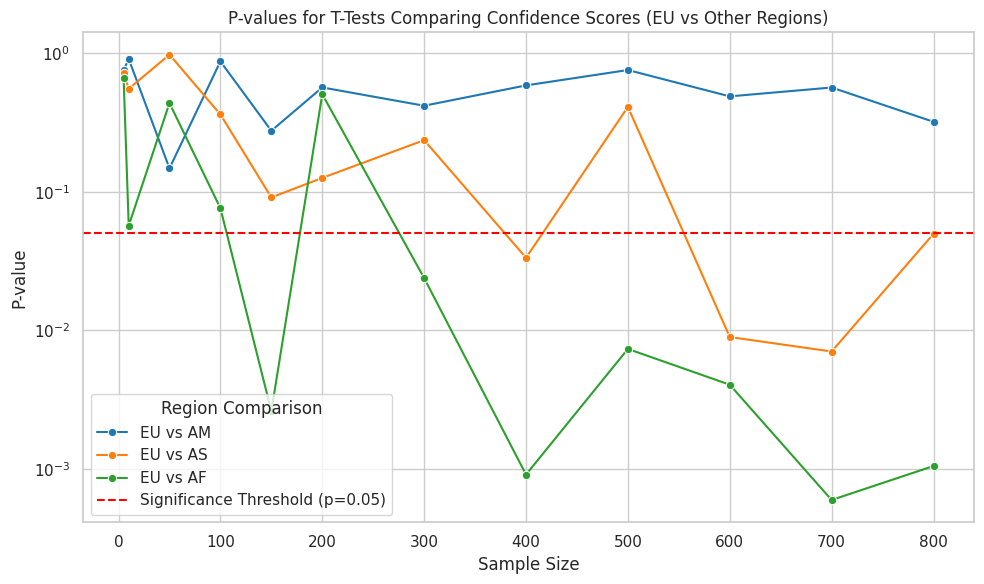

In [7]:
# Set the style for the plot
sns.set(style="whitegrid")

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars='sample_size', value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af'],
                    var_name='Comparison', value_name='p-value')

# Rename columns for better readability in the plot
df_melted['Comparison'] = df_melted['Comparison'].replace({
    'p-value eu vs am': 'EU vs AM',
    'p-value eu vs as': 'EU vs AS',
    'p-value eu vs af': 'EU vs AF'
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='sample_size', y='p-value', hue='Comparison', marker='o', palette='tab10')

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title('P-values for T-Tests Comparing Confidence Scores (EU vs Other Regions)')
plt.xlabel('Sample Size')
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Use logarithmic scale for p-values
plt.legend(title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()


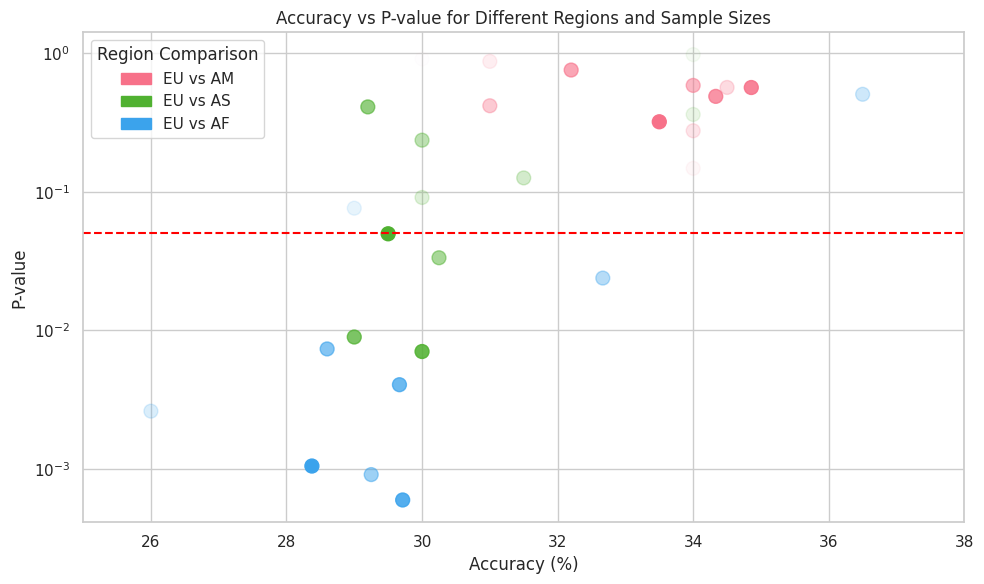

In [18]:
# Prepare the data for plotting
df_melted = df.melt(id_vars='sample_size', 
                    value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af',
                                'accuracy am', 'accuracy as', 'accuracy af'], 
                    var_name='Metric', value_name='Value')

# Extract region and metric type (p-value or accuracy)
df_melted['Region'] = df_melted['Metric'].apply(lambda x: x.split()[-1])  # Get the region (am, as, af)
df_melted['Metric'] = df_melted['Metric'].apply(lambda x: ' '.join(x.split()[:-1]))  # Get metric (p-value or accuracy)

# Pivot the DataFrame to get separate columns for accuracy and p-values
df_plot = df_melted.pivot_table(index=['sample_size', 'Region'], columns='Metric', values='Value').reset_index()

# Normalize the sample size to create a brightness scale for colors
norm = plt.Normalize(df_plot['sample_size'].min(), df_plot['sample_size'].max())

# Set up the color palette
palette = sns.color_palette("husl", 3)  # A color palette with 3 distinct colors for am, as, af
region_colors = {'am': palette[0], 'as': palette[1], 'af': palette[2]}

# Plotting
plt.figure(figsize=(10, 6))
for region in ['am', 'as', 'af']:
    subset = df_plot[df_plot['Region'] == region]
    plt.scatter(subset['accuracy'], subset[f'p-value eu vs'], 
                c=[region_colors[region]] * len(subset), 
                s=100,  # Marker size
                alpha=norm(subset['sample_size']),  # Brighter color for larger sample sizes
                label=f'EU vs {region.upper()}')

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

legend_handles = [
    mpatches.Patch(color=region_colors['am'], label='EU vs AM'),
    mpatches.Patch(color=region_colors['as'], label='EU vs AS'),
    mpatches.Patch(color=region_colors['af'], label='EU vs AF')
]

# Customize the plot
plt.title('Accuracy vs P-value for Different Regions and Sample Sizes')
plt.xlabel('Accuracy (%)')
plt.xlim(25, 38)
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Log scale for p-values for better visibility
plt.legend(handles=legend_handles, title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
import numpy as np
from statsmodels.stats.weightstats import ttost_ind

# Sample data: scores of two groups of students
x1 = np.array([85, 88, 90, 92, 87, 95, 89])
x2 = np.array([83, 85, 91, 86, 88, 93, 87])

# Define equivalence bounds
low = -2  # Lower bound of equivalence interval
upp = 2   # Upper bound of equivalence interval

# Perform TOST
tost_result = ttost_ind(x1, x2, low=0.1*np.mean(x1), upp=0.1*np.mean(x1), usevar='unequal')

# Display the result
print("TOST result:\n", tost_result)


TOST result:
 (0.9989735853324988, (-3.917146061105362, 0.9989735853324988, 11.977170171094293), (-3.917146061105362, 0.0010264146675011791, 11.977170171094293))


In [16]:
import numpy as np
from scipy import stats

def satterthwaite_dof(s1, n1, s2, n2):
    """Calculate the Satterthwaite degrees of freedom."""
    numerator = (s1**2/n1 + s2**2/n2)**2
    denominator = ((s1**2/n1)**2 / (n1 - 1)) + ((s2**2/n2)**2 / (n2 - 1))
    return numerator / denominator

def correct_custom_tost_with_satterthwaite(sample1, sample2, threshold_low, threshold_upp, equal_var=False):
    """
    Perform a corrected custom TOST with Satterthwaite's degrees of freedom.
    sample1: array of values for sample 1 (typically validation data provided by model provider)
    sample2: array of values for sample 2 (typically sample provided by model user)
    threshold_low: lower bound of the equivalence interval as a fraction of the mean of sample1.
    threshold_upp: upper bound of the equivalence interval as a fraction of the mean of sample1.
    equal_var: if False, uses Welch's t-test.
    Returns: 
    """

    # Calculate means and standard deviations
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = len(sample1), len(sample2)
    mean_diff = mean1 - mean2
    low = mean1 * threshold_low
    upp = mean1 * threshold_upp

    # Calculate standard error of the difference
    se_diff = np.sqrt(std1**2/n1 + std2**2/n2)

    # Satterthwaite's degrees of freedom
    dof = satterthwaite_dof(std1, n1, std2, n2)

    # Lower bound test
    t_stat_low = (mean_diff - low) / se_diff
    p_value_low = 1 - stats.t.cdf(t_stat_low, df=dof)

    # Upper bound test
    t_stat_upp = (mean_diff - upp) / se_diff
    p_value_upp = 1 - stats.t.cdf(-t_stat_upp, df=dof)


    # Return the results
    return t_stat_low, p_value_low, t_stat_upp, p_value_upp, dof


# Perform corrected custom TOST with Satterthwaite approximation
correct_tost_results = correct_custom_tost_with_satterthwaite(x1, x2, threshold_low=0.1, threshold_up=0.1)

# Display the results
print("Corrected Custom TOST results with Satterthwaite approximation:")
print(f"Lower bound t-statistic: {correct_tost_results['t_stat_low']}, p-value: {correct_tost_results['p_value_low']}")
print(f"Upper bound t-statistic: {correct_tost_results['t_stat_upp']}, p-value: {correct_tost_results['p_value_upp']}")
print(f"Degrees of Freedom: {correct_tost_results['degrees_of_freedom']}")


Corrected Custom TOST results with Satterthwaite approximation:
Lower bound t-statistic: -3.917146061105362, p-value: 0.9989735853324988
Upper bound t-statistic: -3.917146061105362, p-value: 0.0010264146675011965
Degrees of Freedom: 11.977170171094297
